## Kesimpulan Hasil General Analisis

- Penambahan kasus harian COVID-19 berkorelasi negatif terhadap variabel Jumlah Penumpang dan Jumlah Kapal beroperasi. Hal ini berarti semakin tinggi kasus harian COVID-19 maka jumlah penumpang dan kapal yang beroperasi akan cenderung menurun. Menurunnya jumlah penumpang dan kapal yang beroperasi akan merugikan pelaku usaha transportasi ini, perlu adanya rekomendasi jumlah kapal yang sebaiknya beroperasi perhari berdasarkan kondisi kesehatan (kasus COVID-19) yang tersedia.<br>
- Data observasi kapal feri merupakan data internal yang paling banyak jumlah barisnya, dan menarik untuk kita modelkan menggunakan **Machine Learning**, sehingga hasil prediksi yang didapat nantinya dapat mendukung rekomendasi bisnis usaha kapal feri di masa pandemi ini yang cenderung menurun. Rekomendasi jumlah kapal yang beroperasi akan menghemat biaya operasional pelaku usaha transportasi kapal cepat di Kepulauan Seribu.

## Kenapa Machine Learning?

![alt text](img/da_ml.png "Kenapa Machine Learning")

## Approach

#### 1. Machine Learning Flow Chart
![alt text](img/ml_sg_flow.png "Machine Learning Flow Chart")

#### 2.  Plan
- Menyiapkan Dataset Kapal masing-masing pelabuhan<br>
- Menjadikan jumlah penumpang sebagai target<br>
- Menyiapkan prediktor seperti kasus positif COVID-19, Google Mobility<br>
- Melakukan cek korelasi prediktor terhadap target<br>
- Transformasi DATASET MOBILITY dan Target<br>
- Fit model, tuning model, dan evaluasi performa model<br>
- **Semua rangkaian diatas dilakukan secara iteratif dan berbeda untuk masing-masing pelabuhan**.

## Prepare

#### Library User: Pandas, Numpy, Sklearn, Statsmodels, and Pycaret

In [1]:
# define path
path = "dat_filtered/"

# import library data processing
import pandas as pd
import numpy as np

# import library for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# import self module
from prepare_load import *

# import ML library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

# pycaret regression
#from pycaret.regression import *
from pycaret.classification import *

#### Load dataset

In [2]:
# load kapal dataset
import xlrd
xlsx = xlrd.open_workbook(path+"dataframe_pivot_pelabuhan_v2.xlsx", on_demand=True)
sheet_names = xlsx.sheet_names()
print(sheet_names)
sheet_names.remove("All")

['All', 'KELAPA_HARAPAN', 'LANCANG', 'MARINA', 'ANGKE', 'PARI', 'PRAMUKA_PANGGANG', 'SABIRA', 'TIDUNG_PAYUNG', 'UNTUNG_JAWA']


In [3]:
# dictionary of kapa dataframe per pelabuhan
df_kapal = {item:pd.read_excel(path+"dataframe_pivot_pelabuhan_v2.xlsx", 
                               sheet_name=item) for item in sheet_names}

# dataframe of new case COVID-19 and Google Mobility
case_mobi_custom = pd.read_excel(path+"New_case_mobility_customDate.xlsx")

# check Shape
print("KELAPA_HARAPAN: ", df_kapal["KELAPA_HARAPAN"].shape)
print("Mobility and New Case custom: ", case_mobi_custom.shape)

KELAPA_HARAPAN:  (578, 13)
Mobility and New Case custom:  (578, 6)


**1. KELAPA_HARAPAN**

In [4]:
df_procc = df_kapal["KELAPA_HARAPAN"]
#fastDescribe(df_procc)

df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)

##### Transform

In [5]:
# function to transform

def mobilityTRansform(list_a):
    list_out = []
    for item in list_a:
        if item>=0:
            list_out.append(1)
        elif item<0:
            list_out.append(0)
    return list_out

def labelTransform(list_a):
    import statistics
    before_pandemi = list_a[0:427]
    med_ = statistics.median(before_pandemi)
    list_label = [1 if item >= med_ else 0 for item in list_a]
    return list_label


df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
df_procc1["Is_normal"] = labelTransform(df_procc1["Jumlah Penumpang"].tolist())

In [6]:
df_procc1["Retail_recreation"].value_counts()

1    428
0    150
Name: Retail_recreation, dtype: int64

In [7]:
df_procc1["Is_normal"].value_counts()

0    349
1    229
Name: Is_normal, dtype: int64

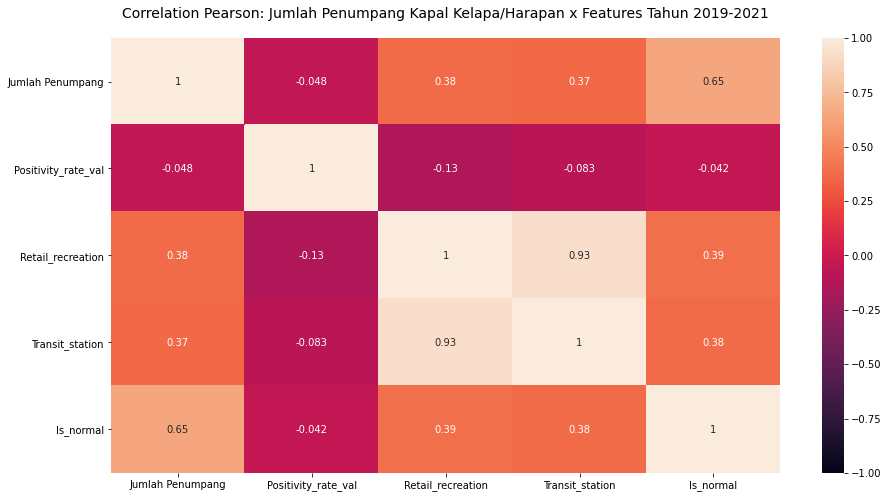

In [8]:
# Check Correlation
# visualize correlation pearson

plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(df_procc1.corr(method="pearson"), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Pearson: Jumlah Penumpang Kapal Kelapa/Harapan x Features Tahun 2019-2021', fontdict={'fontsize':14}, pad=20);

In [9]:
# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Retail_recreation", "Is_normal"]]

In [10]:
# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2221)

Setup Succesfully Completed!


,Description,Value
0,session_id,2221
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [11]:
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.6313,0.6866,0.9438,0.5198,0.6695,0.3247,0.4078,0.0290
1,CatBoost Classifier,0.6289,0.6832,0.9438,0.5178,0.6680,0.3208,0.4042,0.8237
2,Logistic Regression,0.6240,0.6781,0.9438,0.5143,0.6651,0.3131,0.3975,0.0112
3,Naive Bayes,0.6240,0.6824,0.9438,0.5143,0.6651,0.3131,0.3975,0.0034
4,Ridge Classifier,0.6240,0.0000,0.9438,0.5143,0.6651,0.3131,0.3975,0.0112
5,Quadratic Discriminant Analysis,0.6240,0.6781,0.9438,0.5143,0.6651,0.3131,0.3975,0.0074
6,Linear Discriminant Analysis,0.6240,0.6781,0.9438,0.5143,0.6651,0.3131,0.3975,0.0091
7,Random Forest Classifier,0.6166,0.6615,0.9438,0.5099,0.6611,0.3023,0.3881,0.1145
8,Extreme Gradient Boosting,0.6165,0.6600,0.9438,0.5099,0.6610,0.3019,0.3882,0.0625
9,Ada Boost Classifier,0.6116,0.6522,0.9438,0.5063,0.6581,0.2944,0.3815,0.0852


In [13]:
# create model
KELAPA_HARAPAN = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6098,0.6738,0.9375,0.5000,0.6522,0.2916,0.3716
1,0.6098,0.6800,1.0000,0.5000,0.6667,0.3051,0.4243
2,0.6341,0.6725,0.8125,0.5200,0.6341,0.3019,0.3325
3,0.6098,0.6675,0.8750,0.5000,0.6364,0.2775,0.3302
4,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
5,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
6,0.6750,0.7266,0.9375,0.5556,0.6977,0.3925,0.4576
7,0.6000,0.6536,0.9375,0.5000,0.6522,0.2727,0.3536
8,0.6750,0.7083,0.9375,0.5556,0.6977,0.3925,0.4576
9,0.6000,0.6667,1.0000,0.5000,0.6667,0.2857,0.4082


In [14]:
# tune model
tuned_KELAPA_HARAPAN = tune_model(KELAPA_HARAPAN)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6098,0.6738,0.9375,0.5000,0.6522,0.2916,0.3716
1,0.6098,0.6800,1.0000,0.5000,0.6667,0.3051,0.4243
2,0.6341,0.6600,0.8125,0.5200,0.6341,0.3019,0.3325
3,0.6098,0.6525,0.8750,0.5000,0.6364,0.2775,0.3302
4,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
5,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
6,0.6750,0.7174,0.9375,0.5556,0.6977,0.3925,0.4576
7,0.6000,0.6510,0.9375,0.5000,0.6522,0.2727,0.3536
8,0.6750,0.7083,0.9375,0.5556,0.6977,0.3925,0.4576
9,0.6000,0.6667,1.0000,0.5000,0.6667,0.2857,0.4082


In [15]:
#tuned_rf optimize parameter default to 'Accuracy'
# plot_model(tuned_KELAPA_HARAPAN, plot = 'parameter')

In [16]:
# predict test set
dff_output = predict_model(tuned_KELAPA_HARAPAN)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.592,0.6585,0.9565,0.4925,0.6502,0.266,0.3591


roc_auc_score:  0.6585231193926846


Text(0.5, 0, 'False positive rate')

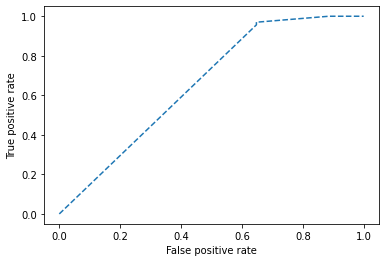

In [17]:
# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [18]:
final_stack_soft = finalize_model(tuned_KELAPA_HARAPAN)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_KELAPA_HARAPAN')

Transformation Pipeline and Model Succesfully Saved


#### 2. LANCANG

In [19]:
df_procc = df_kapal["LANCANG"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)

In [20]:
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
df_procc1["Is_normal"].value_counts()

0    360
1    218
Name: Is_normal, dtype: int64

In [21]:
# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2122)

Setup Succesfully Completed!


,Description,Value
0,session_id,2122
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [22]:
# compare model
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Naive Bayes,0.6438,0.7119,0.9875,0.5177,0.6782,0.3605,0.4572,0.0031
1,Quadratic Discriminant Analysis,0.6438,0.7119,0.9875,0.5177,0.6782,0.3605,0.4572,0.0033
2,Extreme Gradient Boosting,0.6438,0.7103,0.9875,0.5177,0.6782,0.3605,0.4572,0.0148
3,CatBoost Classifier,0.6438,0.7097,0.9875,0.5177,0.6782,0.3605,0.4572,0.8121
4,K Neighbors Classifier,0.6413,0.7100,0.9875,0.5163,0.6769,0.3571,0.4543,0.0031
5,Decision Tree Classifier,0.6413,0.7079,0.9875,0.5160,0.6767,0.3567,0.4542,0.0038
6,SVM - Linear Kernel,0.6413,0.0000,0.3000,0.1668,0.2144,0.1249,0.1369,0.0039
7,Ada Boost Classifier,0.6413,0.7065,0.9875,0.5160,0.6767,0.3567,0.4542,0.0945
8,Gradient Boosting Classifier,0.6413,0.7077,0.9875,0.5160,0.6767,0.3567,0.4542,0.0612
9,Extra Trees Classifier,0.6413,0.7079,0.9875,0.5160,0.6767,0.3567,0.4542,0.1648


In [23]:
# create model
LANCANG = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6585,0.7113,0.9375,0.5357,0.6818,0.3678,0.4377
1,0.5122,0.5863,0.9375,0.4412,0.6000,0.1476,0.2301
2,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
3,0.7317,0.7885,1.0000,0.5769,0.7317,0.4994,0.5769
4,0.7000,0.7600,1.0000,0.5556,0.7143,0.4483,0.5375
5,0.6250,0.7000,1.0000,0.5000,0.6667,0.3333,0.4472
6,0.7250,0.7800,1.0000,0.5769,0.7317,0.4884,0.5684
7,0.6750,0.7400,1.0000,0.5357,0.6977,0.4091,0.5071
8,0.5750,0.6600,1.0000,0.4688,0.6383,0.2609,0.3873
9,0.6500,0.7200,1.0000,0.5172,0.6818,0.3708,0.4771


In [24]:
# tune model
tuned_LANCANG = tune_model(LANCANG)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6585,0.7112,0.9375,0.5357,0.6818,0.3678,0.4377
1,0.5122,0.5863,0.9375,0.4412,0.6000,0.1476,0.2301
2,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
3,0.7317,0.7885,1.0000,0.5769,0.7317,0.4994,0.5769
4,0.7000,0.7600,1.0000,0.5556,0.7143,0.4483,0.5375
5,0.6250,0.7000,1.0000,0.5000,0.6667,0.3333,0.4472
6,0.7250,0.7800,1.0000,0.5769,0.7317,0.4884,0.5684
7,0.6750,0.7400,1.0000,0.5357,0.6977,0.4091,0.5071
8,0.5750,0.6600,1.0000,0.4688,0.6383,0.2609,0.3873
9,0.6500,0.7200,1.0000,0.5172,0.6818,0.3708,0.4771


In [25]:
#tuned_rf optimize parameter default to 'Accuracy'
#plot_model(tuned_LANCANG, plot = 'parameter')

In [26]:
# predict test set
dff_output = predict_model(tuned_LANCANG)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6034,0.6775,0.9848,0.4887,0.6533,0.2967,0.4061


roc_auc_score:  0.6776094276094276


Text(0.5, 0, 'False positive rate')

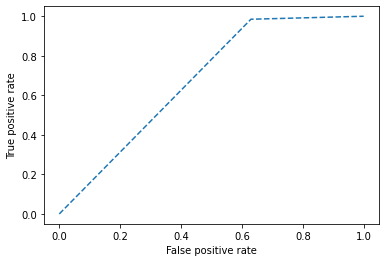

In [27]:
# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [28]:
final_stack_soft = finalize_model(tuned_LANCANG)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_LANCANG')

Transformation Pipeline and Model Succesfully Saved


#### Marina

In [29]:
df_procc = df_kapal["MARINA"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)

In [30]:
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
df_procc1["Is_normal"].value_counts()

0    364
1    214
Name: Is_normal, dtype: int64

In [31]:
# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [32]:
# compare model
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,SVM - Linear Kernel,0.6309,0.0000,0.4000,0.2058,0.2711,0.1403,0.1741,0.0042
1,K Neighbors Classifier,0.6288,0.6832,0.6000,0.3027,0.4015,0.2037,0.2701,0.0037
2,Light Gradient Boosting Machine,0.6287,0.7005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0109
3,Logistic Regression,0.6262,0.6986,0.0000,0.0000,0.0000,-0.0048,-0.0120,0.0102
4,Random Forest Classifier,0.6262,0.7025,0.3000,0.1512,0.2002,0.0984,0.1310,0.1137
5,Naive Bayes,0.6260,0.7025,1.0000,0.5037,0.6683,0.3396,0.4491,0.0037
6,Extreme Gradient Boosting,0.6162,0.7005,0.1000,0.0429,0.0600,0.0158,0.0293,0.0145
7,Ridge Classifier,0.6087,0.0000,0.2000,0.0883,0.1225,0.0384,0.0650,0.0047
8,Decision Tree Classifier,0.5989,0.7005,0.4000,0.1821,0.2502,0.0942,0.1455,0.0030
9,Gradient Boosting Classifier,0.5989,0.7005,0.4000,0.1821,0.2502,0.0942,0.1455,0.0597


In [33]:
# create model
MARINA = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6829,0.7500,1.0000,0.5357,0.6977,0.4225,0.5175
1,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
2,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
3,0.7317,0.7885,1.0000,0.5769,0.7317,0.4994,0.5769
4,0.5000,0.6000,1.0000,0.4286,0.6000,0.1579,0.2928
5,0.6750,0.7400,1.0000,0.5357,0.6977,0.4091,0.5071
6,0.6000,0.6800,1.0000,0.4839,0.6522,0.2967,0.4174
7,0.5500,0.6400,1.0000,0.4545,0.6250,0.2258,0.3568
8,0.6000,0.6800,1.0000,0.4839,0.6522,0.2967,0.4174
9,0.7500,0.8000,1.0000,0.6000,0.7500,0.5294,0.6000


In [34]:
# tune model
tuned_MARINA = tune_model(MARINA)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6829,0.7500,1.0000,0.5357,0.6977,0.4225,0.5175
1,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
2,0.5854,0.6731,1.0000,0.4688,0.6383,0.2792,0.4028
3,0.7317,0.7885,1.0000,0.5769,0.7317,0.4994,0.5769
4,0.5000,0.6000,1.0000,0.4286,0.6000,0.1579,0.2928
5,0.6750,0.7400,1.0000,0.5357,0.6977,0.4091,0.5071
6,0.6000,0.6800,1.0000,0.4839,0.6522,0.2967,0.4174
7,0.5500,0.6400,1.0000,0.4545,0.6250,0.2258,0.3568
8,0.6000,0.6800,1.0000,0.4839,0.6522,0.2967,0.4174
9,0.7500,0.8000,1.0000,0.6000,0.7500,0.5294,0.6000


In [35]:
# predict test set
dff_output = predict_model(tuned_MARINA)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6552,0.7273,1.0,0.5161,0.6809,0.38,0.4844


roc_auc_score:  0.7272727272727273


Text(0.5, 0, 'False positive rate')

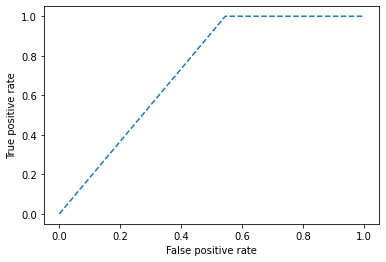

In [36]:
# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [37]:
final_stack_soft = finalize_model(tuned_MARINA)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_MARINA')

Transformation Pipeline and Model Succesfully Saved


#### 4. ANGKE

In [38]:
df_procc = df_kapal["ANGKE"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)

In [39]:
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [40]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Quadratic Discriminant Analysis,0.6064,0.6713,0.9617,0.4992,0.6561,0.2937,0.3886,0.0030
1,Naive Bayes,0.6064,0.6689,0.9617,0.4992,0.6561,0.2937,0.3886,0.0034
2,Light Gradient Boosting Machine,0.5939,0.6674,0.2000,0.0899,0.1240,0.0364,0.0629,0.0138
3,Extreme Gradient Boosting,0.5939,0.6670,0.2000,0.0899,0.1240,0.0364,0.0629,0.0214
4,CatBoost Classifier,0.5939,0.6662,0.2000,0.0899,0.1240,0.0364,0.0629,0.9625
5,K Neighbors Classifier,0.6112,0.6660,0.7679,0.4020,0.5267,0.2412,0.3158,0.0037
6,Logistic Regression,0.6089,0.6623,0.0000,0.0000,0.0000,-0.0049,-0.0124,0.0081
7,Linear Discriminant Analysis,0.5865,0.6623,0.2938,0.1368,0.1865,0.0533,0.0808,0.0037
8,Ada Boost Classifier,0.5816,0.6583,0.2938,0.1354,0.1853,0.0449,0.0639,0.0987
9,Extra Trees Classifier,0.5865,0.6578,0.2000,0.0899,0.1240,0.0218,0.0245,0.2340


In [42]:
# create model
ANGKE = create_model('nb')
# tune model
tuned_ANGKE = tune_model(ANGKE)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5610,0.6312,0.9375,0.4688,0.6250,0.2182,0.3035
1,0.6585,0.7200,1.0000,0.5333,0.6957,0.3801,0.4844
2,0.6341,0.6750,0.9375,0.5172,0.6667,0.3293,0.4047
3,0.5854,0.6600,1.0000,0.4848,0.6531,0.2686,0.3939
4,0.6750,0.7400,1.0000,0.5357,0.6977,0.4091,0.5071
5,0.6000,0.6320,0.8667,0.4815,0.6190,0.2644,0.3170
6,0.5500,0.6400,1.0000,0.4545,0.6250,0.2258,0.3568
7,0.5000,0.5833,1.0000,0.4444,0.6154,0.1379,0.2722
8,0.7000,0.7500,1.0000,0.5714,0.7273,0.4444,0.5345
9,0.6000,0.6576,0.8750,0.5000,0.6364,0.2593,0.3118


In [43]:
# predict test set
dff_output = predict_model(tuned_ANGKE)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6437,0.7022,0.9403,0.5207,0.6702,0.3461,0.4211


roc_auc_score:  0.6988422374110754


Text(0.5, 0, 'False positive rate')

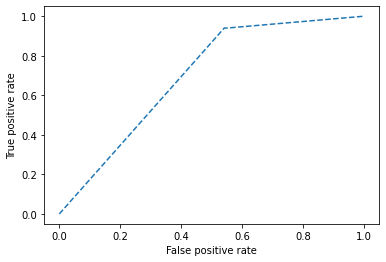

In [44]:
# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [45]:
final_stack_soft = finalize_model(tuned_ANGKE)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_ANGKE')

Transformation Pipeline and Model Succesfully Saved


#### 5. PARI

In [46]:
df_procc = df_kapal["PARI"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)

In [47]:
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [48]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.5845,0.6630,0.1750,0.0858,0.1149,0.0224,0.0373,0.9713
1,Light Gradient Boosting Machine,0.5942,0.6617,0.0750,0.0414,0.0533,0.0061,0.0075,0.0151
2,Naive Bayes,0.5997,0.6615,0.9312,0.4998,0.6487,0.2760,0.3540,0.0030
3,Quadratic Discriminant Analysis,0.5997,0.6594,0.9375,0.4997,0.6501,0.2772,0.3591,0.0033
4,Logistic Regression,0.6015,0.6496,0.0000,0.0000,0.0000,-0.0096,-0.0253,0.0095
5,Linear Discriminant Analysis,0.5820,0.6496,0.1750,0.0844,0.1137,0.0189,0.0331,0.0042
6,K Neighbors Classifier,0.5894,0.6397,0.5688,0.2913,0.3844,0.1448,0.1970,0.0033
7,Extreme Gradient Boosting,0.5696,0.6362,0.1750,0.0858,0.1149,-0.0069,-0.0403,0.0218
8,Gradient Boosting Classifier,0.5573,0.6322,0.2688,0.1299,0.1749,0.0030,-0.0225,0.0765
9,Ada Boost Classifier,0.5573,0.6297,0.2688,0.1299,0.1749,0.0030,-0.0225,0.0940


In [49]:
# create model
PARI = create_model('nb')
# tune model
tuned_PARI = tune_model(PARI)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5854,0.6600,1.0000,0.4848,0.6531,0.2686,0.3939
1,0.5366,0.6050,0.9375,0.4545,0.6122,0.1826,0.2677
2,0.4878,0.5400,0.7500,0.4138,0.5333,0.0611,0.0750
3,0.5122,0.6000,1.0000,0.4444,0.6154,0.1633,0.2981
4,0.7250,0.7800,1.0000,0.5769,0.7317,0.4884,0.5684
5,0.5500,0.6133,0.9375,0.4688,0.6250,0.1964,0.2807
6,0.5750,0.6380,0.8750,0.4828,0.6222,0.2202,0.2743
7,0.6250,0.6901,0.9375,0.5172,0.6667,0.3119,0.3886
8,0.7000,0.7500,1.0000,0.5714,0.7273,0.4444,0.5345
9,0.7000,0.7383,0.8750,0.5833,0.7000,0.4231,0.4583


In [50]:
# predict test set
dff_output = predict_model(tuned_PARI)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6379,0.6883,0.9565,0.5238,0.6769,0.3373,0.4215


roc_auc_score:  0.6897170462387854


Text(0.5, 0, 'False positive rate')

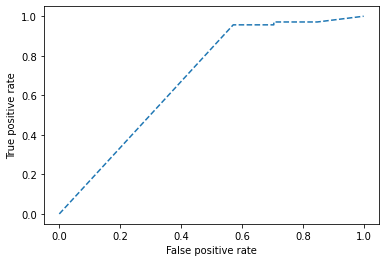

In [51]:
# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [52]:
final_stack_soft = finalize_model(tuned_PARI)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_PARI')

Transformation Pipeline and Model Succesfully Saved


#### 6. PRAMUKA_PANGGANG

In [53]:
df_procc = df_kapal["PRAMUKA_PANGGANG"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [54]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.5893,0.6729,0.3625,0.1850,0.2445,0.0830,0.1163,0.7771
1,Light Gradient Boosting Machine,0.6064,0.6721,0.1000,0.0469,0.0638,0.0261,0.0387,0.0145
2,Naive Bayes,0.6067,0.6713,0.9492,0.4974,0.6517,0.2900,0.3832,0.0032
3,K Neighbors Classifier,0.6042,0.6709,0.7625,0.3955,0.5201,0.2276,0.3039,0.0038
4,Quadratic Discriminant Analysis,0.6067,0.6688,0.9492,0.4974,0.6517,0.2900,0.3832,0.0028
5,Logistic Regression,0.6088,0.6674,0.0062,0.1000,0.0118,-0.0023,-0.0050,0.0099
6,Linear Discriminant Analysis,0.5893,0.6674,0.3688,0.1856,0.2465,0.0849,0.1201,0.0073
7,Extreme Gradient Boosting,0.5795,0.6536,0.3625,0.1809,0.2408,0.0675,0.0931,0.0240
8,Gradient Boosting Classifier,0.5746,0.6474,0.3625,0.1793,0.2395,0.0589,0.0767,0.0776
9,Random Forest Classifier,0.5796,0.6468,0.2625,0.1325,0.1757,0.0328,0.0380,0.1121


In [55]:
# create model
PRAMUKA_PANGGANG = create_model('nb')
# tune model
tuned_PRAMUKA_PANGGANG = tune_model(PRAMUKA_PANGGANG)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5366,0.6075,0.7500,0.4444,0.5581,0.1335,0.1543
1,0.5610,0.6212,0.8750,0.4667,0.6087,0.2030,0.2587
2,0.5610,0.6400,1.0000,0.4706,0.6400,0.2328,0.3630
3,0.6585,0.7200,1.0000,0.5333,0.6957,0.3801,0.4844
4,0.6250,0.7000,1.0000,0.5000,0.6667,0.3333,0.4472
5,0.6500,0.6907,0.8667,0.5200,0.6500,0.3412,0.3867
6,0.5750,0.6600,1.0000,0.4688,0.6383,0.2609,0.3873
7,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
8,0.6750,0.7292,1.0000,0.5517,0.7111,0.4037,0.5029
9,0.5750,0.6458,1.0000,0.4848,0.6531,0.2478,0.3761


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6494,0.7056,0.9706,0.528,0.6839,0.3599,0.4491


roc_auc_score:  0.7060904550499445


Text(0.5, 0, 'False positive rate')

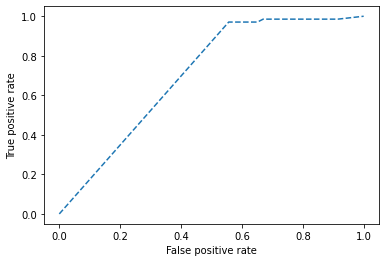

In [56]:
# predict test set
dff_output = predict_model(tuned_PRAMUKA_PANGGANG)

# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [57]:
final_stack_soft = finalize_model(tuned_PRAMUKA_PANGGANG)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_PRAMUKA_PANGGANG')

Transformation Pipeline and Model Succesfully Saved


#### 7. SABIRA

In [58]:
df_procc = df_kapal["SABIRA"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [59]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.5696,0.6565,0.5338,0.2817,0.3683,0.1081,0.1502,0.8314
1,Light Gradient Boosting Machine,0.5696,0.6557,0.5338,0.2817,0.3683,0.1081,0.1502,0.0161
2,Logistic Regression,0.5745,0.6474,0.1643,0.0883,0.1146,0.0120,0.0048,0.0098
3,Linear Discriminant Analysis,0.5646,0.6474,0.5338,0.2787,0.3656,0.1005,0.1428,0.0040
4,K Neighbors Classifier,0.5746,0.6432,0.8276,0.4378,0.5720,0.2000,0.2604,0.0033
5,Quadratic Discriminant Analysis,0.5746,0.6377,0.4397,0.2389,0.3091,0.0899,0.1107,0.0032
6,Naive Bayes,0.5922,0.6307,0.9276,0.4993,0.6480,0.2576,0.3359,0.0037
7,Extreme Gradient Boosting,0.5523,0.6304,0.5338,0.2744,0.3620,0.0794,0.1122,0.0245
8,Ada Boost Classifier,0.5623,0.6282,0.7338,0.3780,0.4984,0.1543,0.2186,0.0922
9,Gradient Boosting Classifier,0.5498,0.6278,0.5338,0.2731,0.3607,0.0757,0.1087,0.0735


In [60]:
# create model
SABIRA = create_model('nb')
# tune model
tuned_SABIRA = tune_model(SABIRA)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5366,0.5686,0.9412,0.4706,0.6275,0.1668,0.2503
1,0.5610,0.6029,0.9412,0.4848,0.6400,0.2047,0.2895
2,0.4878,0.4706,0.7059,0.4286,0.5333,0.0358,0.0415
3,0.5366,0.6000,0.9375,0.4545,0.6122,0.1826,0.2677
4,0.5250,0.5625,1.0000,0.4571,0.6275,0.1739,0.3086
5,0.6500,0.7083,1.0000,0.5333,0.6957,0.3636,0.4714
6,0.5500,0.5716,0.8125,0.4643,0.5909,0.1667,0.2004
7,0.7000,0.7435,0.9375,0.5769,0.7143,0.4340,0.4922
8,0.7000,0.7500,1.0000,0.5714,0.7273,0.4444,0.5345
9,0.6750,0.7292,1.0000,0.5517,0.7111,0.4037,0.5029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.5977,0.6441,0.9,0.5,0.6429,0.2602,0.3228


roc_auc_score:  0.6408653846153847


Text(0.5, 0, 'False positive rate')

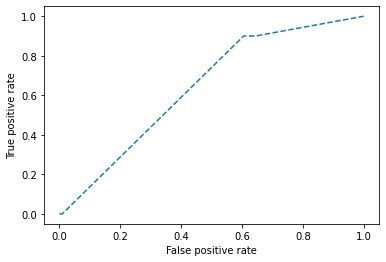

In [61]:
# predict test set
dff_output = predict_model(tuned_SABIRA)

# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [62]:
final_stack_soft = finalize_model(tuned_SABIRA)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_SABIRA')

Transformation Pipeline and Model Succesfully Saved


#### 8. TIDUNG_PAYUNG

In [63]:
df_procc = df_kapal["TIDUNG_PAYUNG"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [64]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Naive Bayes,0.6017,0.6705,0.9542,0.4890,0.6459,0.2883,0.3766,0.0033
1,Quadratic Discriminant Analysis,0.6017,0.6696,0.9542,0.4890,0.6459,0.2883,0.3766,0.0026
2,Light Gradient Boosting Machine,0.6213,0.6678,0.0000,0.0000,0.0000,0.0000,0.0000,0.0140
3,Logistic Regression,0.6189,0.6673,0.0000,0.0000,0.0000,-0.0048,-0.0126,0.0111
4,Linear Discriminant Analysis,0.6213,0.6673,0.0000,0.0000,0.0000,0.0000,0.0000,0.0043
5,CatBoost Classifier,0.6213,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,1.0244
6,K Neighbors Classifier,0.6215,0.6593,0.3804,0.2004,0.2624,0.1253,0.1600,0.0042
7,Extreme Gradient Boosting,0.6139,0.6582,0.0000,0.0000,0.0000,-0.0146,-0.0375,0.0212
8,Random Forest Classifier,0.5940,0.6513,0.2867,0.1379,0.1861,0.0541,0.0648,0.1144
9,Extra Trees Classifier,0.6065,0.6486,0.0000,0.0000,0.0000,-0.0291,-0.0680,0.1782


In [65]:
# create model
TIDUNG_PAYUNG = create_model('nb')
# tune model
tuned_TIDUNG_PAYUNG = tune_model(TIDUNG_PAYUNG)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5122,0.5913,0.9375,0.4412,0.6000,0.1476,0.2301
1,0.6341,0.7000,1.0000,0.5161,0.6809,0.3422,0.4544
2,0.5854,0.6562,0.9375,0.4839,0.6383,0.2545,0.3379
3,0.5854,0.6513,0.8667,0.4643,0.6047,0.2449,0.2999
4,0.6500,0.7200,1.0000,0.5172,0.6818,0.3708,0.4771
5,0.5250,0.6000,0.9333,0.4375,0.5957,0.1739,0.2582
6,0.5500,0.6160,0.9333,0.4516,0.6087,0.2088,0.2937
7,0.6750,0.7307,0.9333,0.5385,0.6829,0.3953,0.4601
8,0.6000,0.6800,1.0000,0.4839,0.6522,0.2967,0.4174
9,0.7000,0.7600,1.0000,0.5556,0.7143,0.4483,0.5375


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6552,0.7269,1.0,0.5238,0.6875,0.3777,0.4825


roc_auc_score:  0.7268518518518519


Text(0.5, 0, 'False positive rate')

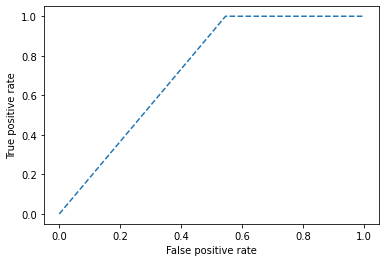

In [66]:
# predict test set
dff_output = predict_model(tuned_TIDUNG_PAYUNG)

# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [67]:
final_stack_soft = finalize_model(tuned_TIDUNG_PAYUNG)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_TIDUNG_PAYUNG')

Transformation Pipeline and Model Succesfully Saved


#### 9. UNTUNG_JAWA

In [68]:
df_procc = df_kapal["UNTUNG_JAWA"]
df_procc1 = df_procc[["Jumlah Penumpang"]]
df_procc1 = df_procc1.copy()
df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()

#fastDescribe(df_procc1)
df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
New_label = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
df_procc1["Is_normal"] = New_label
print(df_procc1["Is_normal"].value_counts())

# select features
df_procc1 = df_procc1[["Positivity_rate_val", "Is_normal", "Retail_recreation"]]

# setup dataset

reg01 = setup(data=df_procc1, target='Is_normal', session_id = 2123)

Setup Succesfully Completed!


,Description,Value
0,session_id,2123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(578, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [69]:
# compare model
top3 = compare_models(n_select = 3, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.5570,0.6324,0.3507,0.1822,0.2392,0.0551,0.0806,0.0165
1,CatBoost Classifier,0.5570,0.6307,0.3507,0.1822,0.2392,0.0551,0.0806,0.7542
2,Naive Bayes,0.5816,0.6306,0.8978,0.4994,0.6398,0.2287,0.2972,0.0034
3,Logistic Regression,0.5618,0.6293,0.2625,0.1852,0.1869,0.0401,0.0590,0.0100
4,Linear Discriminant Analysis,0.5570,0.6293,0.3566,0.2322,0.2497,0.0568,0.0841,0.0040
5,Quadratic Discriminant Analysis,0.5743,0.6279,0.8978,0.4938,0.6356,0.2166,0.2856,0.0031
6,K Neighbors Classifier,0.5716,0.6143,0.6393,0.3421,0.4448,0.1437,0.1980,0.0039
7,Ada Boost Classifier,0.5470,0.6099,0.4272,0.2309,0.2984,0.0552,0.0558,0.0851
8,Extreme Gradient Boosting,0.5396,0.6057,0.3507,0.1770,0.2344,0.0257,0.0296,0.0234
9,Gradient Boosting Classifier,0.5321,0.5936,0.3507,0.1753,0.2331,0.0119,-0.0021,0.0688


In [70]:
# create model
UNTUNG_JAWA = create_model('nb')
# tune model
tuned_UNTUNG_JAWA = tune_model(UNTUNG_JAWA)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5122,0.5784,0.9412,0.4571,0.6154,0.1295,0.2084
1,0.6341,0.6765,0.8235,0.5385,0.6512,0.3003,0.3309
2,0.6585,0.7083,1.0000,0.5484,0.7083,0.3720,0.4780
3,0.5366,0.5931,0.9412,0.4706,0.6275,0.1668,0.2503
4,0.6000,0.6279,0.7647,0.5200,0.6190,0.2289,0.2481
5,0.6500,0.6957,1.0000,0.5484,0.7083,0.3533,0.4632
6,0.6000,0.6407,0.9412,0.5161,0.6667,0.2610,0.3421
7,0.5750,0.6292,0.9412,0.5000,0.6531,0.2202,0.3034
8,0.5250,0.5859,0.9375,0.4545,0.6122,0.1593,0.2417
9,0.5250,0.5703,0.6875,0.4400,0.5366,0.0952,0.1054


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6207,0.6476,0.8904,0.5285,0.6633,0.2887,0.3428


roc_auc_score:  0.6476332564763325


Text(0.5, 0, 'False positive rate')

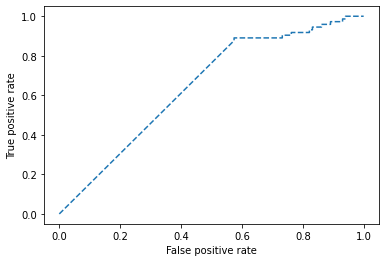

In [71]:
# predict test set
dff_output = predict_model(tuned_UNTUNG_JAWA)

# calculate roc curve
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# define list
list_act = dff_output['Is_normal'].tolist()
list_prob = dff_output['Score'].tolist()

# roc auc score
ns_auc = roc_auc_score(list_act, list_prob)
print("roc_auc_score: ", ns_auc)

# roc curve
ns_fpr, ns_tpr, _ = roc_curve(list_act, list_prob, pos_label="1")

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Xgboost')
pyplot.ylabel("True positive rate")
pyplot.xlabel("False positive rate")

In [72]:
final_stack_soft = finalize_model(tuned_UNTUNG_JAWA)
# save experiment
save_model(final_stack_soft, 'model_2/tuned_UNTUNG_JAWA')

Transformation Pipeline and Model Succesfully Saved


### Hasil:
- Awalnya kami mencoba membuat model regresi, namun nilai R^2 yang sangat kecil membuat kami mencari alternatif lain, yaitu mencoba mengganti label numerical menjadi binary. Pelabelan dilakukan berdasarkan jika jumlah penumpang sama dengan atau lebih dari nilai media sebelum pandemi maka 1, dan selainnya 0.<br>
- Data observasi yang cukup terbatas nampaknya menjadi kendala pemodelan machine learning, nampak pada performa model beberapa muncul nilai 0.<br>
- Keseluruhan nilai performa evaluasi metric model masih belum baik, Accuracy berada pada rentang 0,4-0,6, AUC berada pada rentang 0,6-0,7, dan recall berada pada rentang 0,6-0,9.<br>
- Nilai recall yang cenderung lebih tinggi daripada Acc dan AUC terjadi karena nilai False Negatif kecil.
- **Dengan performa model yang masih belum cukup bagus, untuk membuat decision dibutuhkan aturan (Rule Base) tambahan sehingga hasil prediksi yang didapat akan lebih confidence.**